In [1]:
from estimark.agents import WealthPortfolioLifeCycleConsumerType
from estimark.parameters import init_calibration
from HARK.utilities import plot_funcs
import matplotlib.pyplot as plt
import pandas as pd
from estimark.snp import snp_data, snp_data_full

In [2]:
csv_file_path = "../../content/tables/TRP2/WealthPortfolio_estimate_results.csv"
res = pd.read_csv(csv_file_path, header=None)
res = res.set_index(res.columns[0])[res.columns[1]].to_dict()

In [3]:
portfolio_agent = WealthPortfolioLifeCycleConsumerType(**init_calibration)
portfolio_agent.CRRA = float(res["CRRA"])
portfolio_agent.WealthShare = float(res["WealthShare"])
# portfolio_agent.WealthShift = float(res["WealthShift"])
portfolio_agent.CRRA, portfolio_agent.WealthShare, portfolio_agent.WealthShift

(4.062017216065237, 0.5, 0.0)

In [4]:
portfolio_agent.solve()

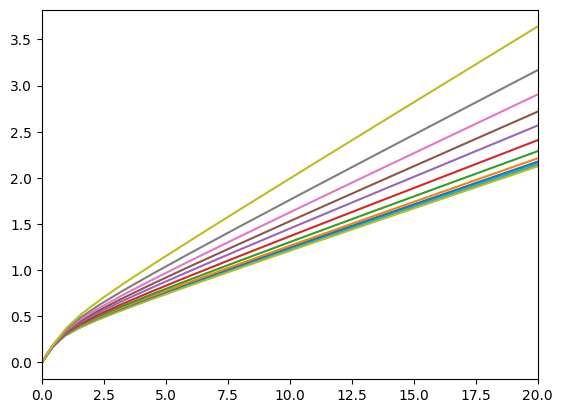

In [5]:
plot_funcs([sol.cFuncAdj for sol in portfolio_agent.solution[:-1:5]], 0, 20)

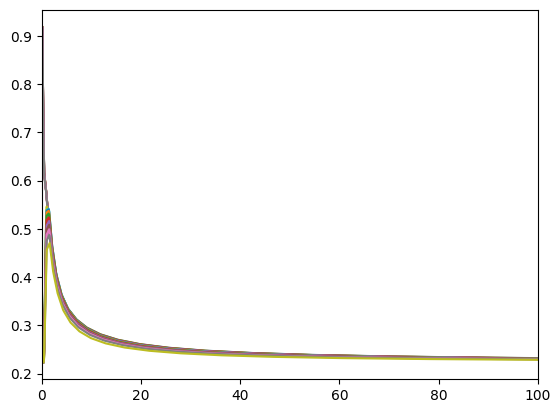

In [6]:
plot_funcs([sol.ShareFuncAdj for sol in portfolio_agent.solution[:-1:5]], 0, 100)
# add Morton-Samuelson

In [7]:
# Set up the variables we want to keep track of.
portfolio_agent.track_vars = ["aNrm", "cNrm", "pLvl", "t_age", "mNrm", "Share"]

portfolio_agent.LivPrb = [1.0] * portfolio_agent.T_cycle

portfolio_agent.T_sim = portfolio_agent.T_cycle + 1
# Run the simulations
portfolio_agent.initialize_sim()
history = portfolio_agent.simulate()

In [8]:
raw_data = {
    "Age": portfolio_agent.history["t_age"].flatten() + 25 - 1,
    "pIncome": portfolio_agent.history["pLvl"].flatten(),
    "nrmM": portfolio_agent.history["mNrm"].flatten(),
    "nrmC": portfolio_agent.history["cNrm"].flatten(),
    "Share": portfolio_agent.history["Share"].flatten(),
}

Data = pd.DataFrame(raw_data)
Data["Cons"] = Data.nrmC * Data.pIncome
Data["M"] = Data.nrmM * Data.pIncome

# Find the mean of each variable at every age
AgeMeans = Data.groupby(["Age"]).median().reset_index()

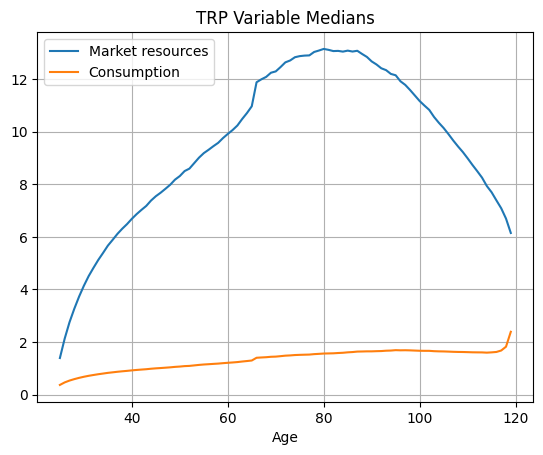

In [9]:
plt.figure()
plt.plot(AgeMeans.Age, AgeMeans.nrmM, label="Market resources")
plt.plot(AgeMeans.Age, AgeMeans.nrmC, label="Consumption")
plt.legend()
plt.xlabel("Age")
plt.title("TRP Variable Medians")
plt.grid()

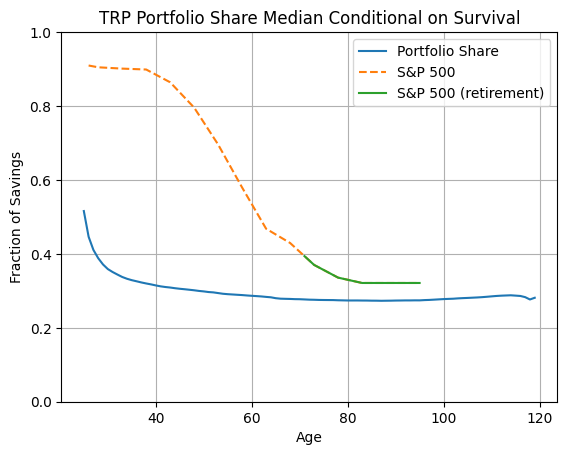

In [10]:
plt.figure()
plt.plot(AgeMeans.Age, AgeMeans.Share, label="Portfolio Share")
plt.plot(
    snp_data_full["age"],
    snp_data_full["share"],
    label="S&P 500",
    linestyle="--",
)
plt.plot(snp_data["age"], snp_data["share"], label="S&P 500 (retirement)")
plt.legend()
plt.xlabel("Age")
plt.ylabel("Fraction of Savings")
plt.title("TRP Portfolio Share Median Conditional on Survival")
plt.ylim(0, 1)
plt.grid()